In [7]:
#!/usr/bin/env python
# coding: utf-8
from __future__ import absolute_import, division, print_function
from tensorflow.keras.layers import Lambda, Dense, Input, Layer, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, LambdaCallback
from tensorflow.keras.initializers import Constant
from tensorflow.keras.backend import concatenate
import tensorflow as tf
import argparse


In [8]:
# import standard modules and DCTR
import os
# os.system('for a in /sys/bus/pci/devices/*; do echo 0 | tee -a $a/numa_node>/dev/null; done') # get rid of NUMA node warnings: https://github.com/tensorflow/tensorflow/issues/42738
# os.system('nvidia-smi')

import sys
sys.path.append('/home/finn/madgraph/MG5_aMC_v2_9_16/')

import numpy as np
import math
import tensorflow as tf 
import keras.backend as K
import pandas as pd

tf.compat.v1.logging.set_verbosity('ERROR')
# make sure GPU usage is enabled
print(tf.config.list_physical_devices('GPU'))


import time
from copy import copy
import csv

# import DCTR
# path_to_DCTR = '/tf/home/gdrive/_STUDIUM_/DCTR_Paper/' # modify as needed
# sys.path.append(path_to_DCTR)
import DCTR


[]


In [9]:
# standard numerical library imports
import numpy as np
import math
import scipy as sp
import matplotlib.pyplot as plt
import os

# energyflow imports
import energyflow as ef
from energyflow.archs import PFN
from energyflow.utils import data_split, to_categorical


In [10]:
data_dir = './git/Data'


In [11]:
# Load pre-normed Datasets: MiNNLO: X1 | POWHEG hvq: X0
# only contain tt-pair; every event has order: 
# tt-pair, top, anti-top
# every particle has arguments: 
# [pt, y, phi, mass, eta, E, PID, w, theta]
# [0 , 1, 2  , 3   , 4  , 5, 6  , 7, 8    ]

# POWHEG hvq
# plotting data; different from training data
X0_plt = []
X0_plt = DCTR.load_dataset(f'{data_dir}/POWHEG_hvq/13TeV/03-04_converted_lhe.npz', i=3)[:9553938] # len of X1 Dataset
print('POWHEG hvq all particles X0_plt.shape: '+str(X0_plt.shape))

X0_test = []
X0_test = DCTR.load_dataset(f'{data_dir}/POWHEG_hvq/13TeV/03-04_normed_converted_lhe.npz', i=3)[:9553938]
print('POWHEG hvq all particles X0_test.shape: '+str(X0_test.shape))



POWHEG hvq all particles X0_plt.shape: (9553938, 3, 9)
POWHEG hvq all particles X0_test.shape: (9553938, 3, 9)


In [12]:
# MiNNLO
# plotting data
X1_plt = []
X1_plt = DCTR.load_dataset(f'{data_dir}/MiNNLO/converted_with_13TeV_NLO/converted_lhe.npz', i=3)
print('MiNNLO all particles X1_plt.shape: '+str(X1_plt.shape))


MiNNLO all particles X1_plt.shape: (9553938, 3, 9)


In [13]:
# get normalized event generator weights

X0_plt_wgt = X0_plt[:, 0, 7].copy()
X0_plt_wgt /= np.mean(X0_plt_wgt) 

X1_plt_wgt = X1_plt[:, 0, 7].copy()
X1_plt_wgt /= np.mean(X1_plt_wgt)


In [14]:
# delete energy
X0_test = np.delete(X0_test, 5, -1)

# delete eta
X0_test = np.delete(X0_test, 4, -1)


In [17]:
model = './best_model.tf'
dctr = tf.keras.models.load_model(model)

with tf.device('CPU'):
    weights_0 = DCTR.get_rwgt([model], X0_test) # .tf models also include network architecture. get_rwgt() sets up the network for the (list of) models, then calls predict_weights() like in DCTR_notebook_OLD_14-to-13TeV notebook

weights_0 /= np.mean(weights_0) # adjust so mean is 1


2024-03-21 15:52:25.607987: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-21 15:52:30.304808: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 573236280 exceeds 10% of free system memory.


In [53]:
'''
dataset=np.load('/eos/cms/store/group/ml/ML4ReweightingHackathon/DCTR/13Hdamp/Down/X_Nom_TestAll_13TeV_test_plot_down.npz')
# print(dataset.files)
X1_test=dataset['a']
print(X1_test.shape)
'''


['a', 'b']
(100000000, 2, 6)


In [46]:
'''
dataset=np.load('/eos/cms/store/group/ml/ML4ReweightingHackathon/DCTR/13Hdamp/Down/X_Down_TestAll_13TeV_plot.npz')
print(dataset.files)
X0_plot=dataset['a']
print(X0_plot.shape)
'''


['a']
(100000000, 8)


In [54]:
'''
dataset=np.load('/eos/cms/store/group/ml/ML4ReweightingHackathon/DCTR/13Hdamp/Down/X_Down_TestAll_13TeV_test.npz')
print(dataset.files)
X0_test=dataset['a']
print(X0_test.shape)
'''


['a']
(100000000, 2, 6)


In [6]:
'''
dataset=np.load('/eos/cms/store/group/ml/ML4ReweightingHackathon/DCTR/13Hdamp/Down/weights_1_DownHdamp13.npz')
print(dataset.files)
weigths_1=dataset['a']
print(weigths_1.shape)
'''


['a']
(100000000,)


In [18]:
print(X0_plt.shape)
print(X1_plt.shape)


(9553938, 3, 9)
(9553938, 3, 9)


In [19]:
print(len(weights_0[0]))

print(max(weights_0[0]))
print(min(weights_0[0]))



9553938
421.81683
0.0


In [20]:
pythia_text = r'$POWHEG \; (hvq) \; pp \to  t\bar{t}$'
def make_legend(ax, title):
    leg = ax.legend(frameon=False)
    leg.set_title(title, prop={'size':20})
    leg.texts[0].set_fontsize(20)
    leg._legend_box.align = "left"
    plt.tight_layout()

# Global plot settings
from matplotlib import rc
import matplotlib.font_manager


In [21]:
import mplhep as hep
plt.style.use(hep.style.CMS)

Text(1.0, 1.04, '(13 TeV)')

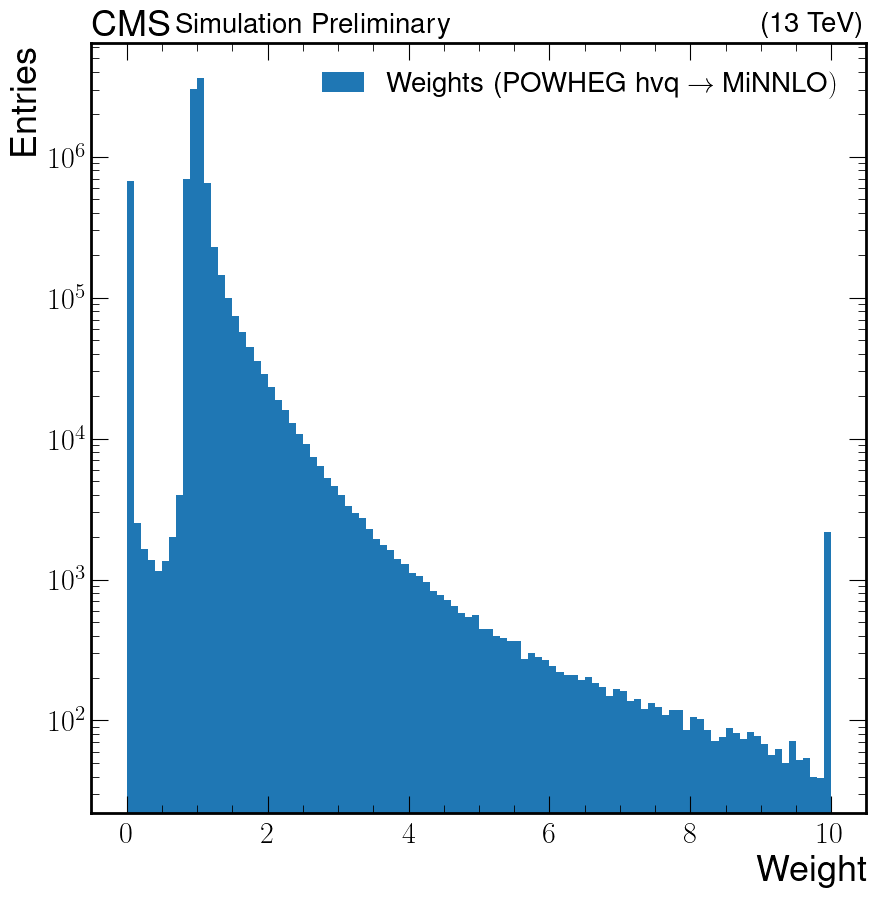

In [22]:
clip_val = 10

label_1=r'MiNNLO'
label_0=r'POWHEG hvq'

#plt.figure(figsize=(8,7))
bins = np.linspace(0, clip_val, 101)
plt.hist(np.clip(weights_0[0], 0, clip_val), bins = bins)
plt.xlabel("Weight")
plt.ylabel('Entries')
plt.legend(labels=["Weights (" + label_0 + r' $\rightarrow$ ' + label_1 +"$ )$"], fontsize=20)
plt.yscale('log')
hep.cms.text("Simulation Preliminary", loc=0, fontsize=20, ax=plt.gca())
plt.text(1.0, 1.04, "(13 TeV)", ha="right", va="top", fontsize=20, transform=plt.gca().transAxes)
# plt.savefig('/eos/cms/store/group/ml/ML4ReweightingHackathon/DCTR/13Hdamp/Down/w1_DownH.pdf')



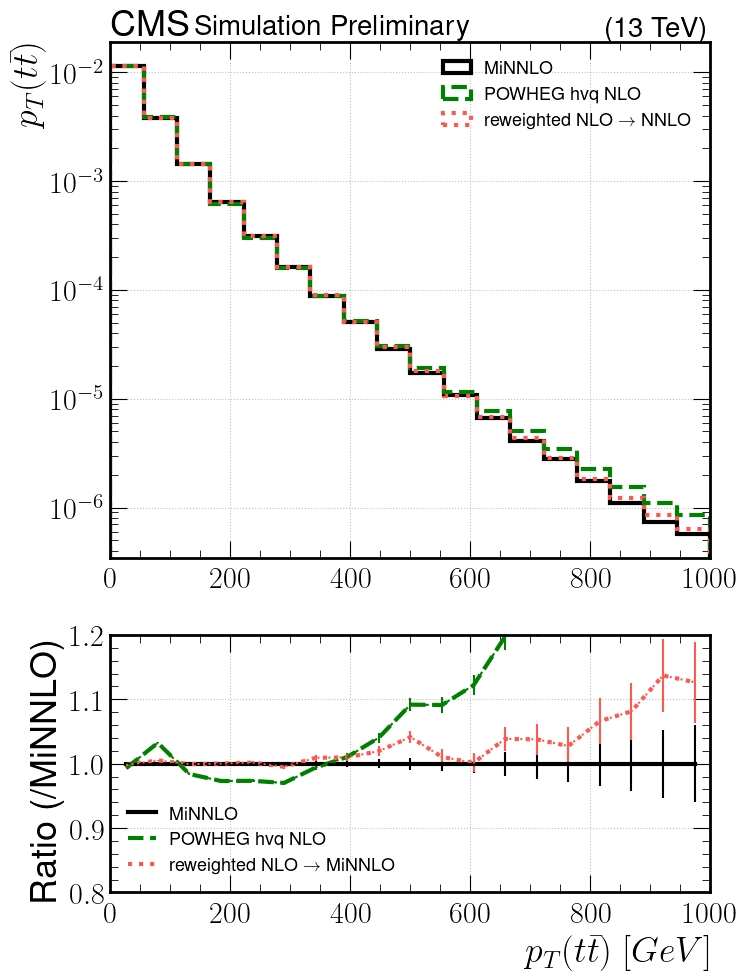

In [23]:
# tt-pair, top, anti-top
# every particle has arguments: 
# [pt, y, phi, mass, eta, E, PID, w, theta]
# [0 , 1, 2  , 3   , 4  , 5, 6  , 7, 8    ]


import mplhep as hep
plt.style.use(hep.style.CMS)

plt_style_10a = {'histtype':'step', 'color':'Green', 'linewidth':3, 'linestyle':'--', 'density':True}
plt_style_11a = {'histtype':'step', 'color':'black', 'linewidth':3, 'linestyle':'-', 'density':True}
plt_style_12a = {'histtype':'step', 'color':'#FC5A50', 'linewidth':3, 'linestyle':':', 'density':True}


# print(len(X0_plt[:,0,0]))
# print(len(weights_0[0]))

hist3, edges3 = np.histogram(X1_plt[:,0,0], bins=19, range=(0, 1000), weights=X1_plt_wgt)
hist5, edges5 = np.histogram(X0_plt[:,0,0], bins=19, range=(0, 1000), weights=X0_plt_wgt)
hist4, edges4 = np.histogram(X0_plt[:,0,0], bins=19, range=(0, 1000), weights=weights_0[0])

# Calculate the ratio of the histograms
ratioNom = hist3 / hist3
ratio_errNom = np.sqrt(hist3) / hist3
ratio = hist4 / hist3
ratio_err = np.sqrt(hist4) / hist3

ratioB = hist5 / hist3
ratio_errB = np.sqrt(hist5) / hist3# Create figure with two subplts
fig, axes = plt.subplots(nrows=2, figsize=(8, 10), gridspec_kw={'height_ratios': [2, 1]})

# First subplot
bins = np.linspace(0, 1000, 19)
hist0 = axes[0].hist(X1_plt[:,0,0], bins=bins, label=r'MiNNLO',  weights=X1_plt_wgt, **plt_style_11a)
hist1 = axes[0].hist(X0_plt[:,0,0], bins=bins, label=r'POWHEG hvq NLO',  weights=X0_plt_wgt, **plt_style_10a)
hist2 = axes[0].hist(X0_plt[:,0,0], bins=bins, label=r'reweighted NLO $\rightarrow$ NNLO', weights=weights_0[0], **plt_style_12a)

make_legend(axes[0], pythia_text)
# axes[0].set_ylabel(r'$1 / \sigma \dfrac{d\sigma}{dp_T(t\bar{t})} \; [Gev^{-1}]$')
axes[0].set_ylabel(r'$p_T(t\bar{t})$')
axes[0].set_yscale('log')
axes[0].grid(True)
axes[0].legend(fontsize=13)


# Second subplot
bin_centers = (edges4[:-1] + edges4[1:]) / 2.0
axes[1].errorbar(bin_centers, ratioNom, yerr=ratio_errNom, fmt='-', color='black')
axes[1].errorbar(bin_centers, ratioB, yerr=ratio_errB, fmt='--', color='green')

axes[1].errorbar(bin_centers, ratio, yerr=ratio_err, fmt=':', color='#FC5A50')
axes[1].plot(bin_centers, ratioNom, '-', color='black',linewidth=3,label=r'MiNNLO')
axes[1].plot(bin_centers, ratioB, '--', color='green',linewidth=3, label=r'POWHEG hvq NLO')
axes[1].plot(bin_centers, ratio, ':', color='#FC5A50',linewidth=3, label=r'reweighted NLO $\rightarrow$ MiNNLO')
axes[1].set_xlabel(r'$p_T(t\bar{t}) \;[GeV]$')
axes[1].set_ylabel('Ratio (/MiNNLO)')
axes[1].grid(True)

axes[1].set_xlim([0,1000])
axes[0].set_xlim([0,1000])

axes[1].set_ylim([0.8,1.20])
axes[1].legend(loc='lower left', fontsize=13)

plt.subplots_adjust(hspace=0.2)
plt.subplots_adjust(left=0.2, right=0.95, bottom=0.1, top=0.95)

#hep.cms.label(ax=axes[0], data=False, paper=False, lumi=None, fontsize=20, loc=0)
hep.cms.text("Simulation Preliminary", loc=0, fontsize=20, ax=axes[0])
axes[0].text(1.0, 1.05, "(13 TeV)", ha="right", va="top", fontsize=20, transform=axes[0].transAxes)

plt.show()

# Save the figure
# plt.savefig('/eos/cms/store/group/ml/ML4ReweightingHackathon/DCTR/13Hdamp/Down/HdampPtRatioDown13TeV.pdf')

NameError: name 'plot_style_11a' is not defined

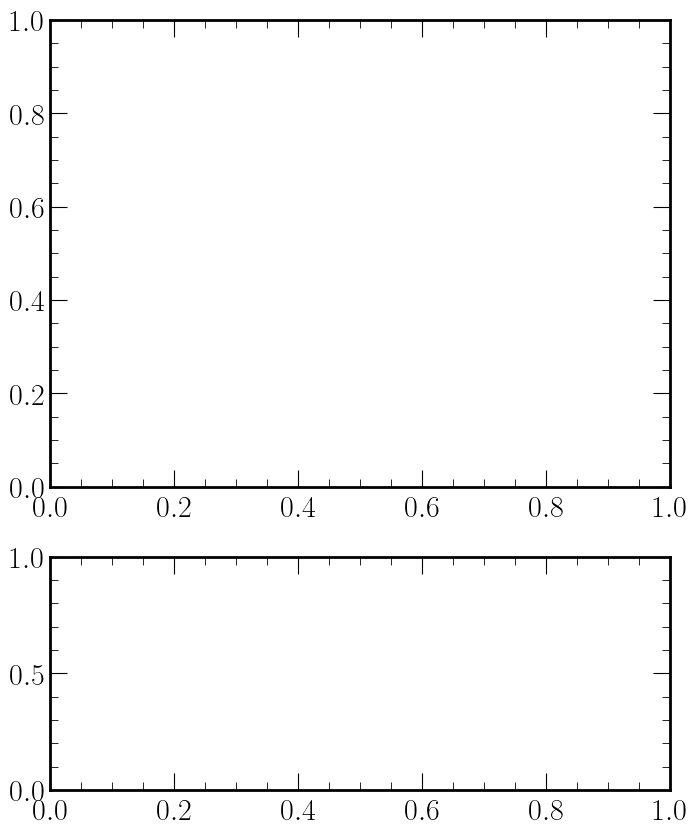

In [24]:
# eta is arg 4, top is particle 1

hist3, edges3 = np.histogram(X1_plt[:,1,4], bins=19, range=(-5, 5), weights=X1_plt_wgt)
hist5, edges5 = np.histogram(X0_plt[:,1,4], bins=19, range=(-5, 5), weights=X0_plt_wgt)
hist4, edges4 = np.histogram(X0_plt[:,1,4], bins=19, range=(-5, 5), weights=weights_0[0])

# Calculate the ratio of the histograms
ratioNom = hist3 / hist3
ratio_errNom = np.sqrt(hist3) / hist3
ratio = hist4 / hist3
ratio_err = np.sqrt(hist4) / hist3

ratioB = hist5 / hist3
ratio_errB = np.sqrt(hist5) / hist3

# Create figure with two subplots
fig, axes = plt.subplots(nrows=2, figsize=(8, 10), gridspec_kw={'height_ratios': [2, 1]})


# First subplot
bins = np.linspace(-5, 5, 19)
hist0 = axes[0].hist(X1_plt[:,1,4], bins=bins, label=r'MiNNLO',  weights=X1_plt_wgt, **plt_style_11a)
hist1 = axes[0].hist(X0_plt[:,1,4], bins=bins, label=r'POWHEG hvq', weights=X0_plt_wgt, **plt_style_10a)
hist2 = axes[0].hist(X0_plt[:,1,4], bins=bins, label=r'reweighted POWHEG NLO $\rightarrow$ MiNNLO', weights=weights_0[0], **plt_style_12a)

make_legend(axes[0], pythia_text)
# axes[0].set_ylabel(r'$1 / \sigma \dfrac{d\sigma}{d\eta(t\bar{t})}$')
axes[0].set_ylabel(r'$\eta (t)$')
axes[0].set_yscale('log')
axes[0].grid(True)
axes[0].legend(loc='upper left', fontsize=13)

# Second subplot
bin_centers = (edges4[:-1] + edges4[1:]) / 2.0
axes[1].errorbar(bin_centers, ratio, yerr=ratio_err, fmt=':', color='#FC5A50')
axes[1].errorbar(bin_centers, ratioNom, yerr=ratio_errNom, fmt='-', color='black')
axes[1].errorbar(bin_centers, ratioB, yerr=ratio_errB, fmt='--', color='green')
axes[1].plot(bin_centers, ratioNom, '-', color='black',linewidth=3, label=r'MiNNLO')
axes[1].plot(bin_centers, ratioB, '--', color='green',linewidth=3, label=r'POWHEG hvq')
axes[1].plot(bin_centers, ratio, ':', color='#FC5A50',linewidth=3, label=r'Reweighted POWHEG')
axes[1].set_xlabel(r'$\eta (t)$')
axes[1].set_ylabel('Ratio(/MiNNLO)')
axes[1].grid(True)

plt.subplots_adjust(hspace=0.2)
plt.subplots_adjust(left=0.2, right=0.95, bottom=0.1, top=0.95)
axes[0].set_ylim([0.04, 1])
axes[1].set_ylim([0.9,1.1])

axes[0].set_xlim([-5,5])
axes[1].set_xlim([-5,5])
axes[1].legend(loc='lower left', fontsize=13)

#hep.cms.label(ax=axes[0], data=False, paper=False, lumi=None, fontsize=20, loc=0)
hep.cms.text("Simulation Preliminary", loc=0, fontsize=20, ax=axes[0])
axes[0].text(1.0, 1.05, "(13 TeV)", ha="right", va="top", fontsize=20, transform=axes[0].transAxes)

# Save the figure
# plt.savefig('/eos/cms/store/group/ml/ML4ReweightingHackathon/DCTR/13Hdamp/Down/HdampEtaRatioDown13TeV.pdf')

